<h2 style="color:blue" align="center">Quantization Tutorial</h2>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

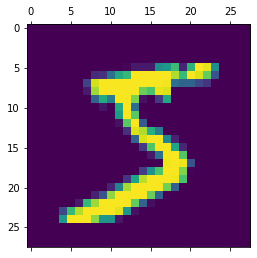

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2734 - accuracy: 0.9226
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1245 - accuracy: 0.9635
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0866 - accuracy: 0.9745
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0652 - accuracy: 0.9800
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0516 - accuracy: 0.9847


In [12]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0888 - accuracy: 0.9708


[0.08878576755523682, 0.97079998254776]

In [13]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

**With quantization**

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [17]:
len(tflite_model)

319792

In [18]:
len(tflite_quant_model)

84752

You can see above that quantizated model is 1/4th the size of a non quantized model

In [19]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [20]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [21]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 28, 28)            3         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 784)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 100)               78505     
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 10)                1015      
Total params: 79,524
Trainable params: 79,510
Non-trainable params: 14
_________________________________________________________________


In [22]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0438 - accuracy: 0.9866


In [23]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0802 - accuracy: 0.9755


[0.08016839623451233, 0.9754999876022339]

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


In [25]:
len(tflite_qaware_model)

82376

In [26]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)